In [42]:
import pandas as pd
from model.getdata import smiles2graph 
from model.CL_model_vas_info import GNNModelWithNewLoss
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [43]:
df = pd.read_csv('data/freesolv.csv')
df.head()

,smiles,freesolv
0,CN(C)C(=O)c1ccc(cc1)OC,-11.01
1,CS(=O)(=O)Cl,-4.87
2,CC(C)C=C,1.83
3,CCc1cnccn1,-5.45
4,CCCCCCCO,-4.21


In [44]:
smiles_list = df["smiles"].tolist()
y = df['freesolv'].tolist()
data_list = smiles2graph(
    smiles_list,
    y = y
)
data_list[0]

Data(x=[13, 133], edge_index=[2, 26], edge_attr=[26, 14], global_features=[1, 8], smiles='CN(C)C(=O)c1ccc(cc1)OC', y=[1, 1])

In [45]:
def load_model_embeddings(data_list, model_dir):
    model_embeddings = []
    for i in range(3):
        model_path = os.path.join(model_dir, str(i), "best_model.pth")

        # Instantiate model with shape matching input data
        model = GNNModelWithNewLoss(
            num_node_features=data_list[0].x.shape[1],
            num_edge_features=data_list[0].edge_attr.shape[1],
            num_global_features=0, # data_list[0].global_features.shape[1],
            hidden_dim=512,
            cov_num = 6
        )

        state_dict = torch.load(model_path, map_location=torch.device("cpu"))
        model.load_state_dict(state_dict['encoder_state_dict'])
        model.eval()

        embeddings = []
        with torch.no_grad():
            for data in data_list:
                emb = model.forward(data.to(torch.device("cpu")))  
                embeddings.append(emb)
        model_embeddings.append(torch.stack(embeddings))
    return model_embeddings

In [46]:
def prepare_dataset(smiles2graph_fn, csv_file, model_dir):
    df = pd.read_csv(csv_file)
    smiles_list = df["smiles"].tolist()
    y = torch.tensor(df["esol"].values, dtype=torch.float32)
    data_list = smiles2graph_fn(smiles_list, y=y)
    embeddings = load_model_embeddings(data_list, model_dir)
    global_features = torch.stack([data.global_features for data in data_list])
    return embeddings, y, global_features

In [47]:
embeddings, y_tensor, global_features = prepare_dataset(smiles2graph, "data/esol.csv", "premodels_new_og/6")


c:\Users\chenxinyi\Documents\GitHub\clean_multi_cl\model\getdata.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  graph.y = torch.tensor(label, dtype=torch.float32).view(1, -1)
C:\Users\chenxinyi\AppData\Local\Temp\ipykernel_32616\3768213957.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicit

In [48]:
embeddings = torch.stack(embeddings, dim=0)
embeddings = embeddings.squeeze(2)
embeddings = embeddings.permute(1, 0, 2)
embeddings.shape

torch.Size([1128, 3, 512])

In [49]:
y_tensor.shape

torch.Size([1128])

In [50]:
N = embeddings.size(0)
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size
generator  = torch.Generator().manual_seed(42)
full_ds = torch.utils.data.TensorDataset(embeddings, y_tensor, global_features)
train_ds, val_ds, test_ds = random_split(full_ds, [train_size, val_size, test_size], generator=generator)

In [51]:
class MolDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.X = torch.from_numpy(embeddings).float()
        self.y = torch.from_numpy(targets).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=32,
    num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=32,
    num_workers=2, pin_memory=True
)

In [52]:
for data in train_loader:
    x,y,g = data
    print(x.shape, y.shape, g.shape)
    break

torch.Size([32, 3, 512]) torch.Size([32]) torch.Size([32, 1, 8])


In [53]:
class TransformerFusionModel(nn.Module):
    def __init__(self, emb_dim, hidden_dim=64):
        super().__init__()
        self.k_proj = nn.Linear(emb_dim, emb_dim)
        self.v_proj = nn.Linear(emb_dim, emb_dim)
        self.query  = nn.Parameter(torch.randn(emb_dim))
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim+32, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
        self.global_encoder = nn.Linear(8, 32)

    def forward(self, x, global_features):
        B, N, D = x.size()
        K = self.k_proj(x)
        V = self.v_proj(x)
        Q = self.query.unsqueeze(0).unsqueeze(1).expand(B, 1, D)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(D)
        weights = torch.softmax(scores, dim=-1)
        fused = torch.matmul(weights, V).squeeze(1)
        global_features = global_features.squeeze(1)
        print(global_features.shape)
        print(fused.shape)
        print(x.shape)
        global_features = self.global_encoder(global_features)
        fused = torch.cat([fused, global_features], dim=-1).squeeze(-1)
        out = self.mlp(fused).squeeze(-1)
        return out, weights.squeeze(1)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim   = embeddings.shape[-1]
model     = TransformerFusionModel(emb_dim=emb_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

epochs = 600
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_train = 0.0
    for xb, yb, global_features in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        global_features = global_features.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds, _ = model(xb,global_features)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append((total_train / len(train_ds))**0.5)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb, global_features in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            global_features = global_features.to(device, non_blocking=True)
            preds, _ = model(xb,global_features)
            total_val += criterion(preds, yb).item() * xb.size(0)
    val_losses.append((total_val / len(val_ds))**0.5)
    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 5

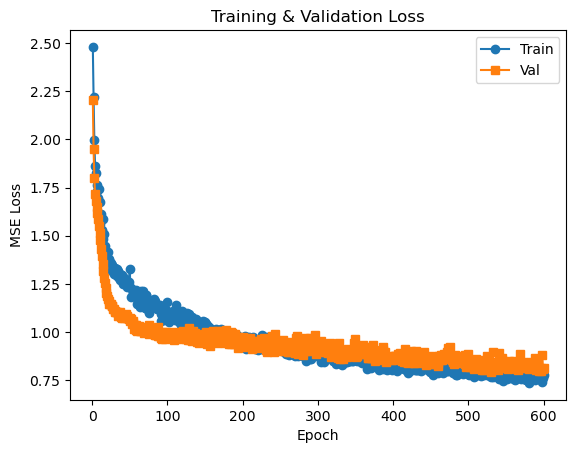

torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
Test Loss: 0.7320
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
Test Loss: 0.7463
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
Test Loss: 0.7537
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
Test Loss: 0.7243
torch.Size([32, 8])
torch.Size([32, 512])
torch.Size([32, 3, 512])
Test Loss: 0.7360
torch.Size([10, 8])
torch.Size([10, 512])
torch.Size([10, 3, 512])
Test Loss: 0.7422


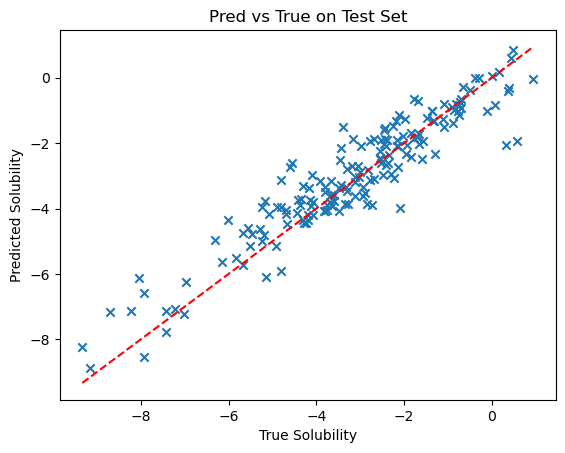

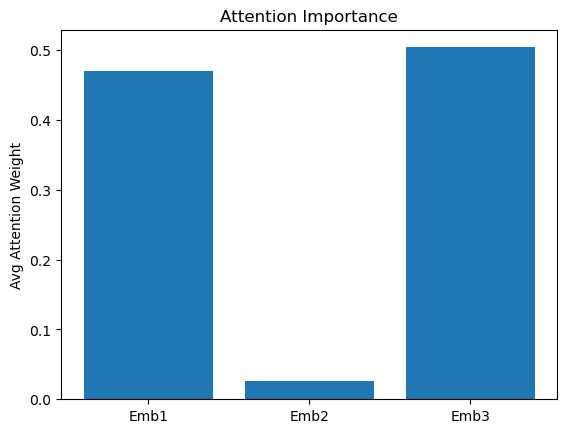

In [55]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train')
plt.plot(range(1, epochs+1), val_losses,   marker='s', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

model.eval()
y_true, y_pred, attn_list = [], [], []
with torch.no_grad():
    for xb, yb, global_features in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        global_features = global_features.to(device, non_blocking=True)
        preds, weights = model(xb, global_features)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        attn_list.append(weights.cpu().numpy())
        test_loss = criterion(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device))**0.5
        print(f"Test Loss: {test_loss.item():.4f}")
attn = np.vstack(attn_list)

plt.figure()
plt.scatter(y_true, y_pred, marker='x')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Pred vs True on Test Set')
plt.show()

avg_weights = attn.mean(axis=0)
plt.figure()
plt.bar(['Emb1','Emb2','Emb3'], avg_weights)
plt.ylabel('Avg Attention Weight')
plt.title('Attention Importance')
plt.show()

In [56]:
class MLP(nn.Module):
    def __init__(self, emb_dim, hidden_dim=64,global_dim=32):
        super().__init__()
        self.global_encoder = nn.Linear(8, global_dim)  # Assuming global features are of size 8
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim+global_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x, global_features):
        global_features = global_features.squeeze(1)
        x = x.view(x.size(0), -1)  # [B, D]
        x = torch.cat([x, self.global_encoder(global_features)], dim=-1)  # [B, D + G]
        out = self.mlp(x).squeeze(-1)
        return out

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim   = embeddings.shape[-1]*3
model     = MLP(emb_dim=emb_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 300
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_train = 0.0
    for xb, yb, global_features in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        global_features = global_features.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds= model(xb, global_features)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append((total_train / len(train_ds))**0.5)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb, global_features in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            global_features = global_features.to(device, non_blocking=True)
            optimizer.zero_grad()
            preds= model(xb, global_features)
            total_val += criterion(preds, yb).item() * xb.size(0)
    val_losses.append((total_val / len(val_ds))**0.5)
    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/300 — Train Loss: 2.9677, Val Loss: 1.6528
Epoch 2/300 — Train Loss: 1.6854, Val Loss: 1.4045
Epoch 3/300 — Train Loss: 1.4688, Val Loss: 1.2106
Epoch 4/300 — Train Loss: 1.3341, Val Loss: 1.0920
Epoch 5/300 — Train Loss: 1.3167, Val Loss: 1.0382
Epoch 6/300 — Train Loss: 1.2175, Val Loss: 1.0503
Epoch 7/300 — Train Loss: 1.2235, Val Loss: 1.0518
Epoch 8/300 — Train Loss: 1.1829, Val Loss: 1.0019
Epoch 9/300 — Train Loss: 1.2214, Val Loss: 1.0514
Epoch 10/300 — Train Loss: 1.1867, Val Loss: 0.9605
Epoch 11/300 — Train Loss: 1.1259, Val Loss: 0.9539
Epoch 12/300 — Train Loss: 1.1022, Val Loss: 0.9699
Epoch 13/300 — Train Loss: 1.1601, Val Loss: 1.1082
Epoch 14/300 — Train Loss: 1.1244, Val Loss: 1.0856
Epoch 15/300 — Train Loss: 1.0855, Val Loss: 0.9964
Epoch 16/300 — Train Loss: 1.1088, Val Loss: 0.9624
Epoch 17/300 — Train Loss: 1.0534, Val Loss: 0.9504
Epoch 18/300 — Train Loss: 1.0605, Val Loss: 0.9508
Epoch 19/300 — Train Loss: 1.0681, Val Loss: 0.9207
Epoch 20/300 — Train 

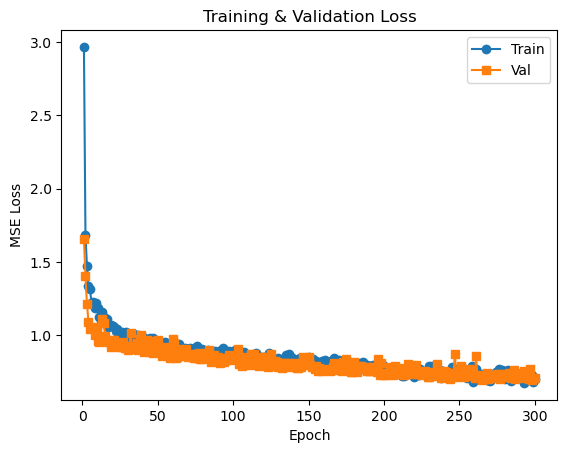

Test Loss: 0.6847
Test Loss: 0.6364
Test Loss: 0.6246
Test Loss: 0.6353
Test Loss: 0.6457
Test Loss: 0.6468


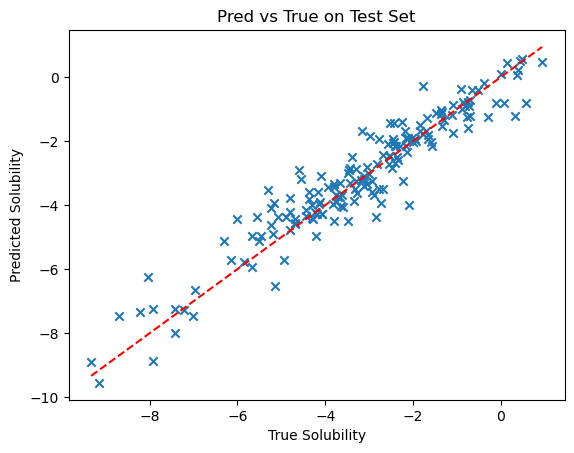

In [59]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train')
plt.plot(range(1, epochs+1), val_losses,   marker='s', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

model.eval()
y_true, y_pred, attn_list = [], [], []
with torch.no_grad():
    for xb, yb, global_features in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        global_features = global_features.to(device, non_blocking=True)
        preds= model(xb, global_features)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        attn_list.append(weights.cpu().numpy())
        test_loss = criterion(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device))**0.5
        print(f"Test Loss: {test_loss.item():.4f}")
attn = np.vstack(attn_list) 

plt.figure()
plt.scatter(y_true, y_pred, marker='x')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Pred vs True on Test Set')
plt.show()

In [60]:
class WeightedFusion(nn.Module):
    def __init__(self, num_inputs=3, emb_dim=512, dropout=0.1, layer_norm_out=True, global_dim=32):
    
        super().__init__()
        self.emb_dim = emb_dim
        self.num_inputs = num_inputs
        self.linear = nn.Sequential(
            nn.Linear(emb_dim, emb_dim), nn.ReLU(),
            nn.Linear(emb_dim, emb_dim)
        )
        self.weight_logits = nn.Parameter(torch.zeros(num_inputs))  # initialized to uniform weights
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(emb_dim) if layer_norm_out else None
        self.global_encoder = nn.Linear(8, global_dim)  # Assuming global features are of size 8
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim+global_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, embs, global_features):  # embs: [B, N, D]
        B, N, D = embs.size()
        x = self.linear(embs)  # shape [B, N, D]
        norm_weights = torch.softmax(self.weight_logits, dim=0)  # shape [N]
        fused = torch.einsum('bnd,n->bd', x, norm_weights)  # [B, D]
        fused = self.dropout(fused)
        if self.layer_norm is not None:
            fused = self.layer_norm(fused)

        global_features = global_features.squeeze(1)
        fused = torch.cat([fused, self.global_encoder(global_features)], dim=-1)  # [B, D + G]

        out = self.mlp(fused).squeeze(-1)
        return out, norm_weights

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim   = embeddings.shape[-1]
model     = WeightedFusion(emb_dim=emb_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-5)

epochs = 100
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_train = 0.0
    for xb, yb, global_features in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        global_features = global_features.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds, _ = model(xb,global_features)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append((total_train / len(train_ds))**0.5)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb, global_features in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            global_features = global_features.to(device, non_blocking=True)
            preds, _ = model(xb,global_features)
            total_val += criterion(preds, yb).item() * xb.size(0)
    val_losses.append((total_val / len(val_ds))**0.5)
    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/100 — Train Loss: 2.2603, Val Loss: 1.6983
Epoch 2/100 — Train Loss: 1.7218, Val Loss: 1.5056
Epoch 3/100 — Train Loss: 1.6031, Val Loss: 1.3243
Epoch 4/100 — Train Loss: 1.4826, Val Loss: 1.1427
Epoch 5/100 — Train Loss: 1.2762, Val Loss: 1.0410
Epoch 6/100 — Train Loss: 1.2645, Val Loss: 1.0300
Epoch 7/100 — Train Loss: 1.2054, Val Loss: 1.0288
Epoch 8/100 — Train Loss: 1.2049, Val Loss: 1.0423
Epoch 9/100 — Train Loss: 1.1844, Val Loss: 0.9805
Epoch 10/100 — Train Loss: 1.2034, Val Loss: 0.9449
Epoch 11/100 — Train Loss: 1.1587, Val Loss: 0.9954
Epoch 12/100 — Train Loss: 1.1125, Val Loss: 1.0251
Epoch 13/100 — Train Loss: 1.1576, Val Loss: 0.9358
Epoch 14/100 — Train Loss: 1.0944, Val Loss: 0.9383
Epoch 15/100 — Train Loss: 1.1619, Val Loss: 0.9643
Epoch 16/100 — Train Loss: 1.1025, Val Loss: 0.9322
Epoch 17/100 — Train Loss: 1.1088, Val Loss: 0.9495
Epoch 18/100 — Train Loss: 1.0486, Val Loss: 0.9634
Epoch 19/100 — Train Loss: 1.0890, Val Loss: 0.9070
Epoch 20/100 — Train 

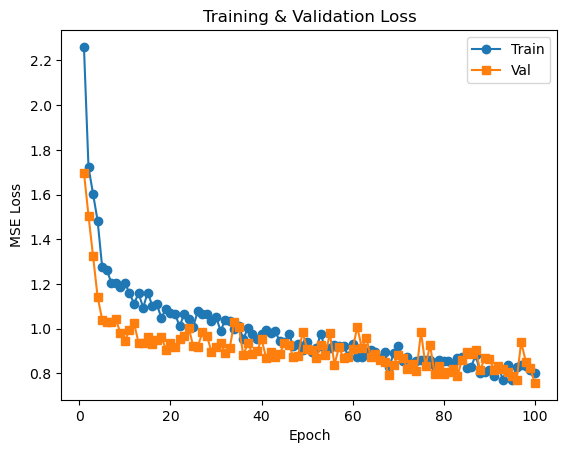

Test Loss: 0.6616
Test Loss: 0.6381
Test Loss: 0.6327
Test Loss: 0.6243
Test Loss: 0.6264
Test Loss: 0.6461


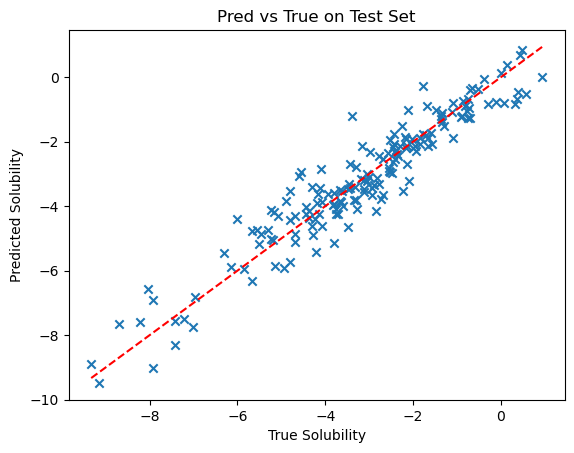

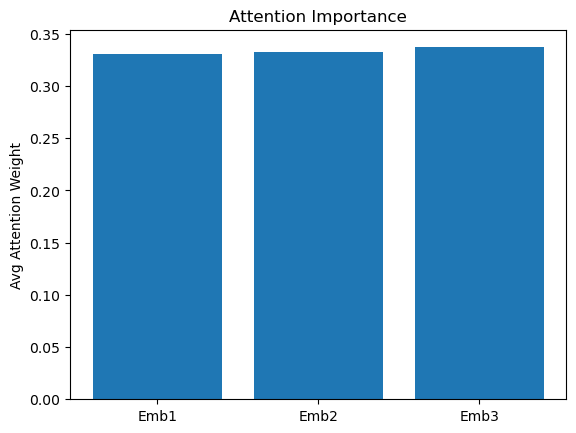

In [63]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train')
plt.plot(range(1, epochs+1), val_losses,   marker='s', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

model.eval()
y_true, y_pred, attn_list = [], [], []
with torch.no_grad():
    for xb, yb, global_features in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        global_features = global_features.to(device, non_blocking=True)
        preds, weights = model(xb,global_features)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        attn_list.append(weights.cpu().numpy())
        test_loss = criterion(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device))**0.5
        print(f"Test Loss: {test_loss.item():.4f}")
attn = np.vstack(attn_list)

plt.figure()
plt.scatter(y_true, y_pred, marker='x')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Pred vs True on Test Set')
plt.show()

avg_weights = attn.mean(axis=0)
plt.figure()
plt.bar(['Emb1','Emb2','Emb3'], avg_weights)
plt.ylabel('Avg Attention Weight')
plt.title('Attention Importance')
plt.show()